# Italian & Asian Gourmet (IAG) Restaurant Chain in Toronto
### Andrija Mihoci
#### The programming support by Alex Aklson and Polong Lin is gratefully acknowledged

Executive Summary

As a part of our business expansion we investigate the possibility to open a chain of IAG restaurants in Toronto. Our data science team is responsible to accomplish the following goals: (i) finding and analyzing clusters of Italian and Asian restaurants in Toronto, (ii) reporting on identified central interest points for our business expansion and restaurant type and (iii) providing a list of streets at focal points that will be used in the negotiations with local entrepreneurs. This app creates all findings of the data science group presented in the report.

### 1. Neighborhoods Data (Postal Code, Borough and Neighborhood)
Source: Wikipedia, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### 1.0 Preparation

In [1]:
# Import libraries
import pandas as pd
import numpy as np

#### 1.1 Data

In [2]:
# Load the data table from the website (as a list) and select the first element
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Define the column names
df.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

# Remove the 'Not assigned' postal codes and reset the index
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)

# Check if a given postal code appears more than once in the table
# If 'df_check_PostalCode != 0', then yes
df_check_PostalCode = sum(df['PostalCode'].value_counts()) - df.shape[0]
#print(df_check_PostalCode)

# Check if there exist a not-assigned neighborhood
# If df_check_Neighborhood != 0, then yes
df_check_Neighborhood = (df['Neighborhood'].values == '').sum()
#print(df_check_Neighborhood)

# Print the first five rows of the dataframe
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### 1.2 Statistics

In [3]:
# Report about the number of postal codes
print(f'\n There are {df.shape[0]} postal codes in Toronto.')


 There are 103 postal codes in Toronto.


### 2. Neighborhoods Data (Postal Code, Borough, Neighborhood, Latitude and Longitude)
Source: Cognitive Class, http://cocl.us/Geospatial_data

#### 2.0 Preparation

In [4]:
# Import libraries
import pandas as pd

#### 2.1 Data

In [5]:
# Load the data about postal code with corresponding
# latitude and longitude information
df_add = pd.read_csv('http://cocl.us/Geospatial_data')

# Define the column names
df_add.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

# Merge the datasets (use an inner join where all matching
# instances in both dataframes are reported, intersection operator)
df_extended = df.merge(df_add, how = 'inner', on = ['PostalCode'])

#### 2.2 Statistics

In [6]:
# Report about the number of postal codes
print(f'\n There are {df_extended.shape[0]} postal codes in Toronto. \n')

# Report on the first postal codes
# Information: postal code, borough, neighborhood, latitude and longitute
print(df_extended[['PostalCode', 'Latitude', 'Longitude']].head().round(2).to_latex(index = False))


 There are 103 postal codes in Toronto. 

\begin{tabular}{lrr}
\toprule
PostalCode &  Latitude &  Longitude \\
\midrule
       M3A &     43.75 &     -79.33 \\
       M4A &     43.73 &     -79.32 \\
       M5A &     43.65 &     -79.36 \\
       M6A &     43.72 &     -79.46 \\
       M7A &     43.66 &     -79.39 \\
\bottomrule
\end{tabular}



### 3. Clustering of Toronto Venue Data

#### 3.0 Preparation

In [7]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [8]:
# @hidden_cell
CLIENT_ID = 'RXI1G55MSY32MTNN3DGDNP0HVAJWZKYD2RB0BMJ3HHWFVXND' # your Foursquare ID (removed before commiting the file to github)
CLIENT_SECRET = 'VLJNGYH3JTPUZGTBOP3DFJTQQDRJ5VXFLPTCAPU0MZSZIJWV' # your Foursquare Secret (removed before commiting the file to github)
VERSION = '20200514' # Foursquare API version

#### 3.1 Data (a): Location Data of Neighborhoods in Toronto

In [9]:
# Create a dataframe of relevant data
# Borough, neighborhood, latitude and longitude
neighborhoods = df_extended.drop(columns = {'PostalCode'})

# Report on the number of boroughs and neighborhoods
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

# Provide the geographical coordinates of Toronto
address = 'Toronto, CA'
geolocator = Nominatim(user_agent = "toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# Create a map of Toronto with marked neighborhoods
map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 10)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)
map_toronto

The dataframe has 10 boroughs and 103 neighborhoods.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


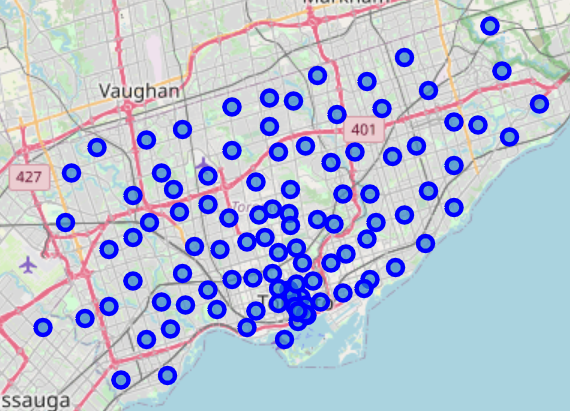

In [10]:
# For convenience, the neighborhoods are displayed as a .png
# For research reproducibility execute the codes above
from IPython.display import Image
Image("Figure_Toronto_Neighborhoods.png")

#### 3.2 Data (b): Data about local Businesses in Toronto

In [11]:
# Select data
toronto_data = neighborhoods
LIMIT = 100

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Function that requests the data on venues
def getNearbyVenues(names, latitudes, longitudes, radius = 5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Data about venues in Toronto neighborhoods
toronto_venues = getNearbyVenues(names = toronto_data['Neighborhood'],
                                 latitudes = toronto_data['Latitude'],
                                 longitudes = toronto_data['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

#### 3.3 Data (c): Data about all Venues in Toronto

In [12]:
# Reporting on the dataframe size (rows: number of vanues, columns: number of variables)
print(toronto_venues.shape)

# Reporting on the number of unique venue categories
toronto_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

# One hot encoding, add neighborhood column back to dataframe,
# move neighborhood column to the first column and grouping data
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(10264, 7)
There are 250 uniques categories.
(98, 250)


,Neighborhood,Zoo Exhibit,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt,0.0,0.0,0.00,0.0,0.01,0.0,0.01,0.01,0.00,0.000000,0.0,0.000000,0.00,0.0,0.00000,0.040000,0.01000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.010000,0.00,0.00,0.0,0.010000,0.0,0.020000,0.01,0.000000,0.00,0.0,0.0,0.02,0.050000,0.0,0.0,0.0,0.080000,0.00,0.0,0.00,0.00,0.00,0.07000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,

#### 3.4 Descriptive Statistics

In [13]:
# Extract restaurants in Toronto from all venues
toronto_restaurants = toronto_grouped.set_index('Neighborhood')
toronto_restaurants = toronto_restaurants.filter(like = ('Restaurant'))

# Exclude restaurants that do not specify the type (see column 'Restaurant')
toronto_restaurants.drop(columns = {'Restaurant'}, inplace = True)

# Consider only the proportion of restaurants of a given type among all restaurants (exclude other venues)
toronto_restaurants.iloc[:, 0 : (toronto_restaurants.shape[1] + 1)] = toronto_restaurants.iloc[:, 0 : (toronto_restaurants.shape[1] + 1)].div(toronto_restaurants.sum(axis = 1), axis = 0)

# Extract the most common restaurant types
print(toronto_restaurants.mean().sort_values(ascending = False)[0 : 10].round(2).to_latex(index = True))

toronto_restaurants.head()

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
Italian Restaurant        &  0.11 \\
Japanese Restaurant       &  0.06 \\
Sushi Restaurant          &  0.06 \\
Indian Restaurant         &  0.06 \\
Middle Eastern Restaurant &  0.05 \\
French Restaurant         &  0.05 \\
Thai Restaurant           &  0.04 \\
American Restaurant       &  0.04 \\
Chinese Restaurant        &  0.04 \\
Mexican Restaurant        &  0.04 \\
\bottomrule
\end{tabular}



,Afghan Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hakka Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,South American Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,0.0,0.021739,0.021739,0.0,0.043478,0.108696,0.0,0.173913,0.0,0.0,0.000000,0.021739,0.0,0.0,0.0,0.043478,0.043478,0.021739,0.000000,0.0,0.043478,0.043478,0.021739,0.021739,0.0,0.065217,0.000000,0.021739,0.043478,0.000000,0.000000,0.0,0.000000,0.021739,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.021739,0.000000,0.021739,0.065217,0.0,0.0,0.0,0.021739,0.0,0.0,0.000000,0.021739,0.043478,0.021739
"Alderwood, Long Branch",0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.090909,0.000000,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.045455,0.045455,0.045455,0.000000,0.0,0.000000,0.045455,0.136364,0.045455,0.0,0.000000,0.0,0.045455,0.000000,0.136364,0.045455,0.000000,0.090909,0.0,0.0,0.0,0.045455,0.0,0.0,0.000000,0.000000,0.090909,0.000000
"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.043478,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.086957,0.0,0.043478,0.000000,0.000000,0.000000,0.0,0.043478,0.043478,0.043478,0.086957,0.000000,0.043478,0.0,0.086957,0.000000,0.130435,0.000000,0.0,0.000000,0.0,0.000000,0.043478,0.043478,0.000000,0.000000,0.086957,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.000000,0.086957,0.000000
Bayview Village,0.0,0.000000,0.000000,0.0,0.000000,0.055556,0.0,0.055556,0.0,0.0,0.027778,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.027778,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.027778,0.111111,0.000000,0.111111,0.0,0.027778,0.000000,0.166667,0.000000,0.0,0.027778,0.0,0.000000,0.055556,0.083333,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.027778,0.027778,0.000000
"Bedford Park, Lawrence Manor East",0.0,0.055556,0.055556,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.055556,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.055556,0.055556,0.111111,0.111111,0.000000,0.055556,0.0,0.000000,0.000000,0.000000,0.055556,0.0,0.000000,0.0,0.000000,0.055556,0.055556,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.111111,0.0,0.0,0.000000,0.000000,0.000000,0.000000


#### 3.5 Cluster Analysis: Machine Learning Algorithm

In [14]:
# Data Matrix
toronto_data = neighborhoods.drop_duplicates(subset = 'Neighborhood', keep = 'first')
toronto_data = toronto_data.sort_values(by = 'Neighborhood').drop(columns = 'Borough').reset_index(drop = True) # All neighborhoods (103)

X = pd.merge(left = toronto_restaurants, right = toronto_data, how = 'inner', \
             left_on = 'Neighborhood', right_on = 'Neighborhood')

# Cluster Analysis using the kNN Algorithm
kclusters = 2
X_clustering = X.drop('Neighborhood', 1)
k_means = KMeans(n_clusters = kclusters, random_state = 0).fit(X_clustering)
k_means_cluster_centers = k_means.cluster_centers_
X_clustering.insert(0, 'Cluster Labels', k_means.labels_)
X_clustering.insert(0, 'Neighborhood', toronto_data['Neighborhood'])
X_clustering = X_clustering[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels']].merge(X)
X_clustering

,Neighborhood,Latitude,Longitude,Cluster Labels,Afghan Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hakka Restaurant,Hong Kong Restaurant,Hotpot Restaurant,Hungarian Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,South American Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Agincourt,43.794200,-79.262029,0,0.000000,0.021739,0.021739,0.000000,0.043478,0.108696,0.000000,0.173913,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.043478,0.043478,0.021739,0.000000,0.000000,0.043478,0.043478,0.021739,0.021739,0.000000,0.065217,0.000000,0.021739,0.043478,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.021739,0.065217,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.021739,0.043478,0.021739
1,"Alderwood, Long Branch",43.602414,-79.543484,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.045455,0.000000,0.000000,0.000000,0.045455,0.136364,0.045455,0.000000,0.000000,0.000000,0.045455,0.000000,0.136364,0.045455,0.000000,0.090909,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.043478,0.086957,0.000000,0.043478,0.000000,0.086957,0.000000,0.130435,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.043478,0.000000,0.086957,0.000000
3,Bayview Village,43.786947,-79.385975,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.111111,0.000000,0.111111,0.000000,0.027778,0.000000,0.166667,0.000000,0.000000,0.027778,0.000000,0.000000,0.055556,0.083333,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.027778,0.027778,0.000000
4,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.111111,0.111111,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Berczy Park,43.644771,-79.373306,0,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.

#### 3.6 Cluster Analysis: Clusters of selected Restaurant Types

In [15]:
X_clustering_restaurants = X_clustering[['Neighborhood', 'Latitude', 'Longitude', 'Cluster Labels', \
                                          'Italian Restaurant', 'Japanese Restaurant', 'Sushi Restaurant']]
X_clustering_restaurants

,Neighborhood,Latitude,Longitude,Cluster Labels,Italian Restaurant,Japanese Restaurant,Sushi Restaurant
0,Agincourt,43.794200,-79.262029,0,0.021739,0.043478,0.065217
1,"Alderwood, Long Branch",43.602414,-79.543484,0,0.045455,0.045455,0.090909
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,0.043478,0.086957,0.086957
3,Bayview Village,43.786947,-79.385975,0,0.027778,0.111111,0.055556
4,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,0.111111,0.111111,0.166667
5,Berczy Park,43.644771,-79.373306,0,0.000000,0.083333,0.083333
6,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,0.000000,0.058824,0.058824
7,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,0,0.000000,0.153846,0.153846
8,Business reply mail Processing Centre,43.662744,-79.321558,0,0.090909,0.000000,0.090909
9,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0,0.000000,0.153846,0.076923


#### 3.7 Cluster Analysis: Graphical Illustration of Restaurant Clusters

In [16]:
# Create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
rainbow = ['#001aff', '#8000ff']
print(rainbow)

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X_clustering['Latitude'], X_clustering['Longitude'], X_clustering['Neighborhood'], X_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
map_clusters

['#8000ff', '#ff0000']
['#001aff', '#8000ff']


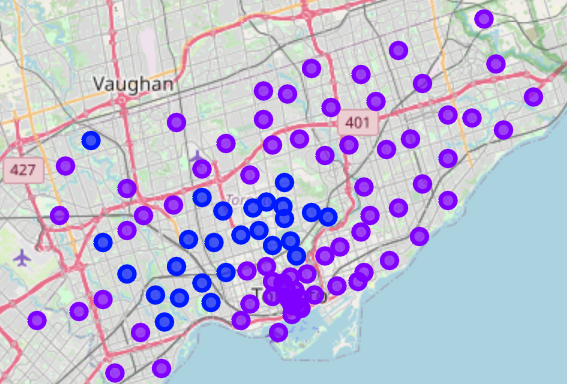

In [17]:
# For convenience, the clusters are displayed as a .png
# For research reproducibility execute the codes above
from IPython.display import Image
Image("Figure_Toronto_Clusters.png")

#### 3.8 Cluster Analysis: Italian Restaurant, Focal Point 1

In [18]:
# Focal Point 1
print(X_clustering_restaurants[X_clustering_restaurants['Cluster Labels'] == 1].mean()[3 : 6].round(2).to_latex(index = True))

print(f'The 1st focal point has coordinates {k_means_cluster_centers[1][-2]}, {k_means_cluster_centers[1][-1]}')

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
Italian Restaurant  &  0.30 \\
Japanese Restaurant &  0.05 \\
Sushi Restaurant    &  0.06 \\
\bottomrule
\end{tabular}

The 1st focal point has coordinates 43.69032395384615, -79.44370215000001


#### 3.9 Cluster Analysis: Japanese and Sushi Restaurants, Focal Point 2

In [19]:
# Focal Point 2
print(X_clustering_restaurants[X_clustering_restaurants['Cluster Labels'] == 0].mean()[3 : 6].round(2).to_latex(index = True))

print(f'The 2nd focal point has coordinates {k_means_cluster_centers[0][-2]}, {k_means_cluster_centers[0][-1]}') 

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
Italian Restaurant  &  0.05 \\
Japanese Restaurant &  0.07 \\
Sushi Restaurant    &  0.06 \\
\bottomrule
\end{tabular}

The 2nd focal point has coordinates 43.70678326944444, -79.37588432361112


#### 3.10 Cluster Analysis: Focal Points

In [20]:
# All Results
print(f'The 1st focal point "Oakwood Avenue" has coordinates {k_means_cluster_centers[1][-2]}, {k_means_cluster_centers[1][-1]}')
print(f'The 2nd focal point "Bayview Avenue" has coordinates {k_means_cluster_centers[0][-2]}, {k_means_cluster_centers[0][-1]}') 
print(f'The 3rd focal point "Avenue Road" has coordinates {(k_means_cluster_centers[0][-2] + k_means_cluster_centers[1][-2]) / 2},\
{(k_means_cluster_centers[0][-1] + k_means_cluster_centers[1][-1]) / 2}') 

folium.Marker([k_means_cluster_centers[1][-2], k_means_cluster_centers[1][-1]], icon = folium.Icon(color = 'darkblue', icon = 'icon')).add_to(map_clusters)
folium.Marker([k_means_cluster_centers[0][-2], k_means_cluster_centers[0][-1]], icon = folium.Icon(color = 'purple', icon = 'icon')).add_to(map_clusters)
folium.Marker([(k_means_cluster_centers[0][-2] + k_means_cluster_centers[1][-2]) / 2, \
               (k_means_cluster_centers[0][-1] + k_means_cluster_centers[1][-1]) / 2], icon = folium.Icon(color = 'green', icon = 'icon')).add_to(map_clusters)
map_clusters

The 1st focal point "Oakwood Avenue" has coordinates 43.69032395384615, -79.44370215000001
The 2nd focal point "Bayview Avenue" has coordinates 43.70678326944444, -79.37588432361112
The 3rd focal point "Avenue Road" has coordinates 43.698553611645295,-79.40979323680557


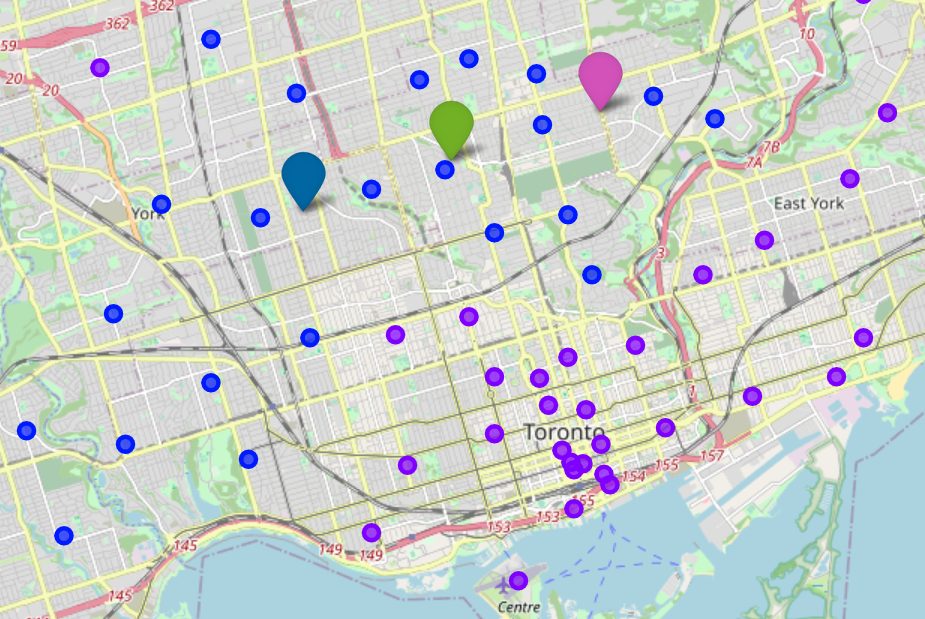

In [21]:
# For convenience, the clusters are displayed as a .png
# For research reproducibility execute the codes above
from IPython.display import Image
Image("Figure_Toronto_Focal_Points.png")

## Summary: Italian & Asian Gourmet (IAG) Restaurant Chain in Toronto

### 1. Neighborhoods Data (Postal Code, Borough and Neighborhood), accomplished
### 2. Neighborhoods Data (Postal Code, Borough, Neighborhood, Latitude and Longitude), accomplished
### 3. Clustering of Toronto Venue Data, accomplished